In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%run cleaning_acled.ipynb
%run cleaning_ucdp.ipynb

2011-08-19 00:00:00
60


In [33]:
country = "south_sudan"
ucleaner = UCDPCleaner(country)

ucleaner.load_data(use_high=True)
ucdp = ucleaner.data


In [43]:
ucdp_month = ucleaner.duration()
ucdp_month = ucdp[ucdp['duration'] <= pd.Timedelta(days=31)]
ucdp_month['duration'].value_counts()

0 days     573
1 days      87
2 days      48
3 days      27
30 days     26
6 days      23
7 days      16
4 days      16
29 days     13
9 days      10
5 days       8
27 days      8
10 days      7
14 days      7
11 days      5
15 days      5
13 days      5
17 days      5
31 days      4
28 days      4
8 days       4
21 days      4
20 days      4
18 days      3
16 days      1
24 days      1
Name: duration, dtype: int64

In [47]:
# Splitting the best estimate among the number of months encompassed by the total duration and adding this as a separate entry to ucdp_month
ucdp_long = ucdp[ucdp['duration'] > pd.Timedelta(days=31)]

# Calculate the number of months for each entry
ucdp_long['months_duration'] = ucdp_long['duration'].apply(lambda x: np.ceil(x.days / 30))

# Split the 'best' estimate among the number of months
ucdp_long['best_per_month'] = ucdp_long['best'] / ucdp_long['months_duration']

# Creating new rows for each month of duration
rows = []
for _, row in ucdp_long.iterrows():
    for month in range(int(row['months_duration'])):
        new_row = row.copy()
        new_row['best'] = row['best_per_month']
        # Assuming 'date_start' is the column to increment by month. Adjust if the actual date column name differs.
        new_row['date_start'] = row['date_start'] + pd.DateOffset(months=month)
        rows.append(new_row)

# Convert the list of new rows into a DataFrame
new_entries = pd.DataFrame(rows)

# Append these new entries to ucdp_month
ucdp_month = pd.concat([ucdp_month, new_entries], ignore_index=True)


/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_98748/3548960300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucdp_long['months_duration'] = ucdp_long['duration'].apply(lambda x: np.ceil(x.days / 30))
/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_98748/3548960300.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucdp_long['best_per_month'] = ucdp_long['best'] / ucdp_long['months_duration']


In [48]:
print(ucdp.shape)
print(ucdp_month.shape)

(974, 50)
(1131, 52)


In [49]:
ucdp_month_resampled = ucdp_month.set_index('date_start').resample('M').agg({
    'best': 'sum',
    'conflict_new_id': lambda x: x.nunique(),
    'duration': 'mean',
    'id': 'count'
}).rename(columns={'conflict_new_id': 'unique_conflicts', 'duration': 'avg_duration', 'id': 'events_count'})

ucdp_month_resampled


,best,unique_conflicts,avg_duration,events_count
date_start,,,,
2011-08-31,700.0,2,0 days 04:48:00,5
2011-09-30,52.0,3,0 days 04:48:00,5
2011-10-31,98.0,4,11 days 17:08:34.285714285,7
2011-11-30,34.0,2,14 days 16:00:00,6
2011-12-31,310.0,3,9 days 12:00:00,10
...,...,...,...,...
2022-08-31,34.2,1,79 days 00:00:00,5
2022-09-30,73.2,1,95 days 12:00:00,4
2022-10-31,43.2,2,76 days 09:36:00,5


dates range from 2011-08-18 to 2022-12-24


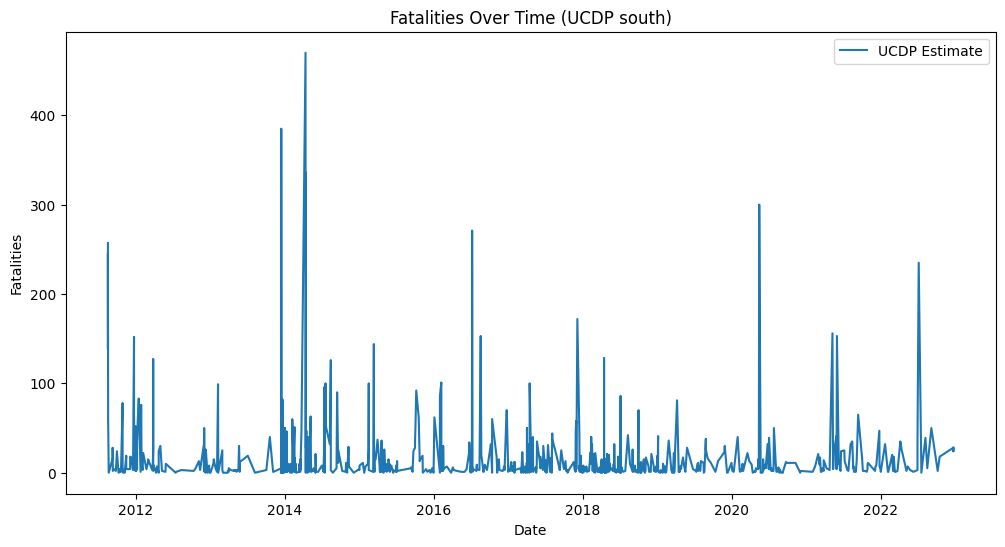

In [16]:
ucleaner.plot()

In [ ]:
from scipy.stats import zscore

# Calculate the Z-Score for the 'best' column
ucdp_month_resampled['z_score'] = zscore(ucdp_month_resampled['best'])

# Identify peaks with a Z-Score greater than 1
ucdp_month_resampled['peak'] = ucdp_month_resampled['z_score'] > 1

dates range from 2011-08-31 to 2022-12-31


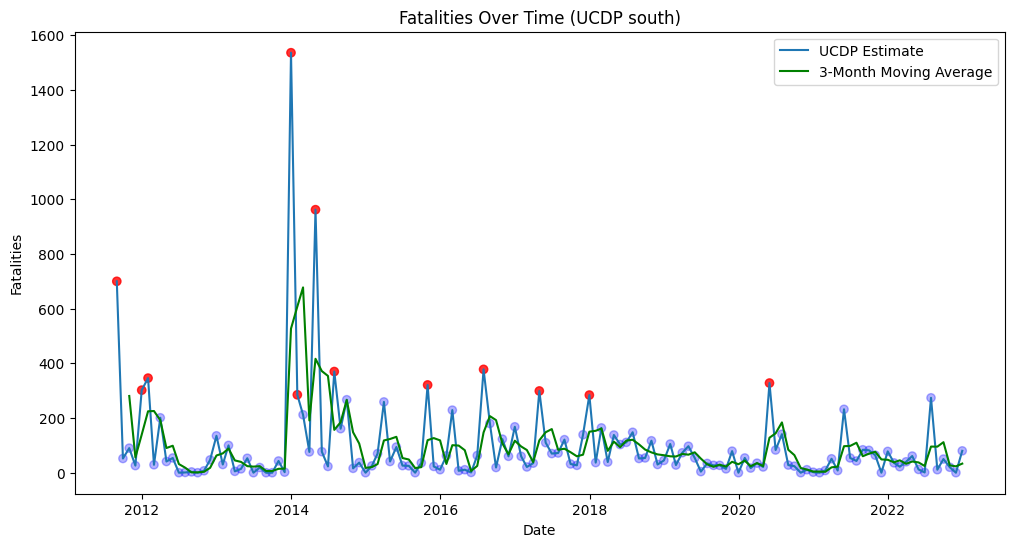

In [42]:
target_ucdp = ucdp_month_resampled["best"]
dates_ucdp = ucdp_month_resampled.index
print(f'dates range from {dates_ucdp.min().date()} to {dates_ucdp.max().date()}')

plt.figure(figsize=(12, 6))
plt.plot(dates_ucdp, target_ucdp, label='UCDP Estimate')  # Changed from scatter to plot
plt.scatter(dates_ucdp, target_ucdp, c=ucdp_month_resampled['peak'].map({True: 'red', False: 'blue'}), alpha=ucdp_month_resampled['peak'].map({True: 0.8, False: 0.3}))  # Keep coloring based on 'peak'
plt.plot(dates_ucdp, target_ucdp.rolling(window=3).mean(), label='3-Month Moving Average', color='green')  # Changed from scatter to plot
plt.xlabel('Date')
plt.ylabel('Fatalities')

plt.title(f'Fatalities Over Time (UCDP {ucleaner.region_name})')  # Assuming self.region_name is meant to be ucleaner.region_name
plt.legend()
plt.show()

date_start
2011-08-31     True
2011-09-30    False
2011-10-31    False
2011-11-30    False
2011-12-31     True
              ...  
2022-08-31    False
2022-09-30    False
2022-10-31    False
2022-11-30    False
2022-12-31    False
Freq: M, Name: peak, Length: 137, dtype: bool